In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
np.random.seed(69)
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns
sns.set()
# from tqdm.notebook 
import tqdm
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import time
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader


In [2]:
X = np.load("/scratch/srinadb/Foundation/Dataset/Experiment1/X_exp1.npy")
dnnx = np.load("/scratch/srinadb/Foundation/Dataset/Experiment1/dnnx_exp1.npy")
objlist = np.load("/scratch/srinadb/Foundation/Dataset/Experiment1/objlist_exp1.npy")
y = np.load("/scratch/srinadb/Foundation/Dataset/Experiment1/y_exp1.npy", allow_pickle=True)

# idx_drop = np.where(y=="QSO")[0]
# X = np.delete(X,idx_drop,axis=0)
# dnnx = np.delete(dnnx,idx_drop,axis=0)
# y = np.delete(y,idx_drop,axis=0)
# objlist = np.delete(objlist,idx_drop,axis=0)
y, label_strings = pd.factorize(y,sort=True)
# y = to_categorical(y)
print('\n')
print(label_strings)



['GALAXY' 'QSO' 'STAR']


In [3]:
zipX = list(zip(X, dnnx))
zipy = list(zip(y, objlist))

zipX_train, zipX_test, zipy_train, zipy_test = train_test_split(zipX, zipy, test_size = 0.125,random_state=42)
zipX_train, zipX_val, zipy_train, zipy_val = train_test_split(zipX_train, zipy_train, test_size = 0.1428, random_state=42)

X_train, dnnx_train = zip(*zipX_train)
X_val, dnnx_val = zip(*zipX_val)
X_test, dnnx_test = zip(*zipX_test)

y_train, objlist_train = zip(*zipy_train)
y_val, objlist_val = zip(*zipy_val)
y_test, objlist_test = zip(*zipy_test)

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

dnnx_train = np.array(dnnx_train)
dnnx_val = np.array(dnnx_val)
dnnx_test = np.array(dnnx_test)

y_train = np.array(y_train)
objlist_train = np.array(objlist_train)
y_val = np.array(y_val)
objlist_val = np.array(objlist_val)
y_test = np.array(y_test)
objlist_test = np.array(objlist_test)

del(zipX,zipX_test,zipX_train,zipX_val, X, zipy, zipy_test, zipy_train, zipy_val, objlist)

X_train = X_train.transpose((0, 3, 1, 2))
X_val = X_val.transpose((0, 3, 1, 2))
X_test = X_test.transpose((0, 3, 1, 2))

print('\n')
print('The shape of the Train data is:', X_train.shape)
print('The shape of the Validation data is:', X_val.shape)
print('The shape of the Test data is:', X_test.shape)



The shape of the Train data is: (180011, 5, 32, 32)
The shape of the Validation data is: (29988, 5, 32, 32)
The shape of the Test data is: (30000, 5, 32, 32)


In [4]:
def get_metrics(y_pred, y_test, labels, to_print=True):
    correct_labels = np.where(y_pred==y_test)[0]
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred,average='macro')
    recall = metrics.recall_score(y_test, y_pred,average='macro')
    f1score = metrics.f1_score(y_test, y_pred,average='macro')
    # rocscore = metrics.roc_auc_score(y_test, y_pred,average='micro',multi_class="ovo")
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)  
    classification_report = metrics.classification_report(y_test, y_pred)

    if to_print:
        print("Identified {} correct labels out of {} labels".format(len(correct_labels), y_test.shape[0]))
        print("Accuracy:",accuracy)
        print("Precision:",precision)
        print("Recall:",recall)
        print("F1 Score:",f1score)
        # print("ROC AUC Score:",rocscore)
        print(f"Labels are: {labels}")
        print("Confusion Matrix:\n", confusion_matrix)
        print("Classification_Report:\n", classification_report)

    return (correct_labels, accuracy, precision, recall, confusion_matrix, classification_report)

In [5]:
n_classes = 3
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
in_channels = X_train.shape[1]

cuda:0


Images: train=(180011, 5, 32, 32), val=(29988, 5, 32, 32), test=(30000, 5, 32, 32) | bands=5, size=32x32
Photometry dims: 24 | classes=3

[Dataset counts]
 Train : {'GALAXY': 60061, 'QSO': 59962, 'STAR': 59988}
 Val   : {'GALAXY': 9918, 'QSO': 10037, 'STAR': 10033}
 Test  : {'GALAXY': 10020, 'QSO': 10001, 'STAR': 9979}

(Expected) Train 59988/60061/59962 ; Val 10033/9918/10037 ; Test 9979/10020/10001 (stars/galaxies/quasars)
[Config] AUG_PROFILE=2, CLS_MODE=photometry, PATCH=4, EMBED_DIM=256, HEADS=8, K=32


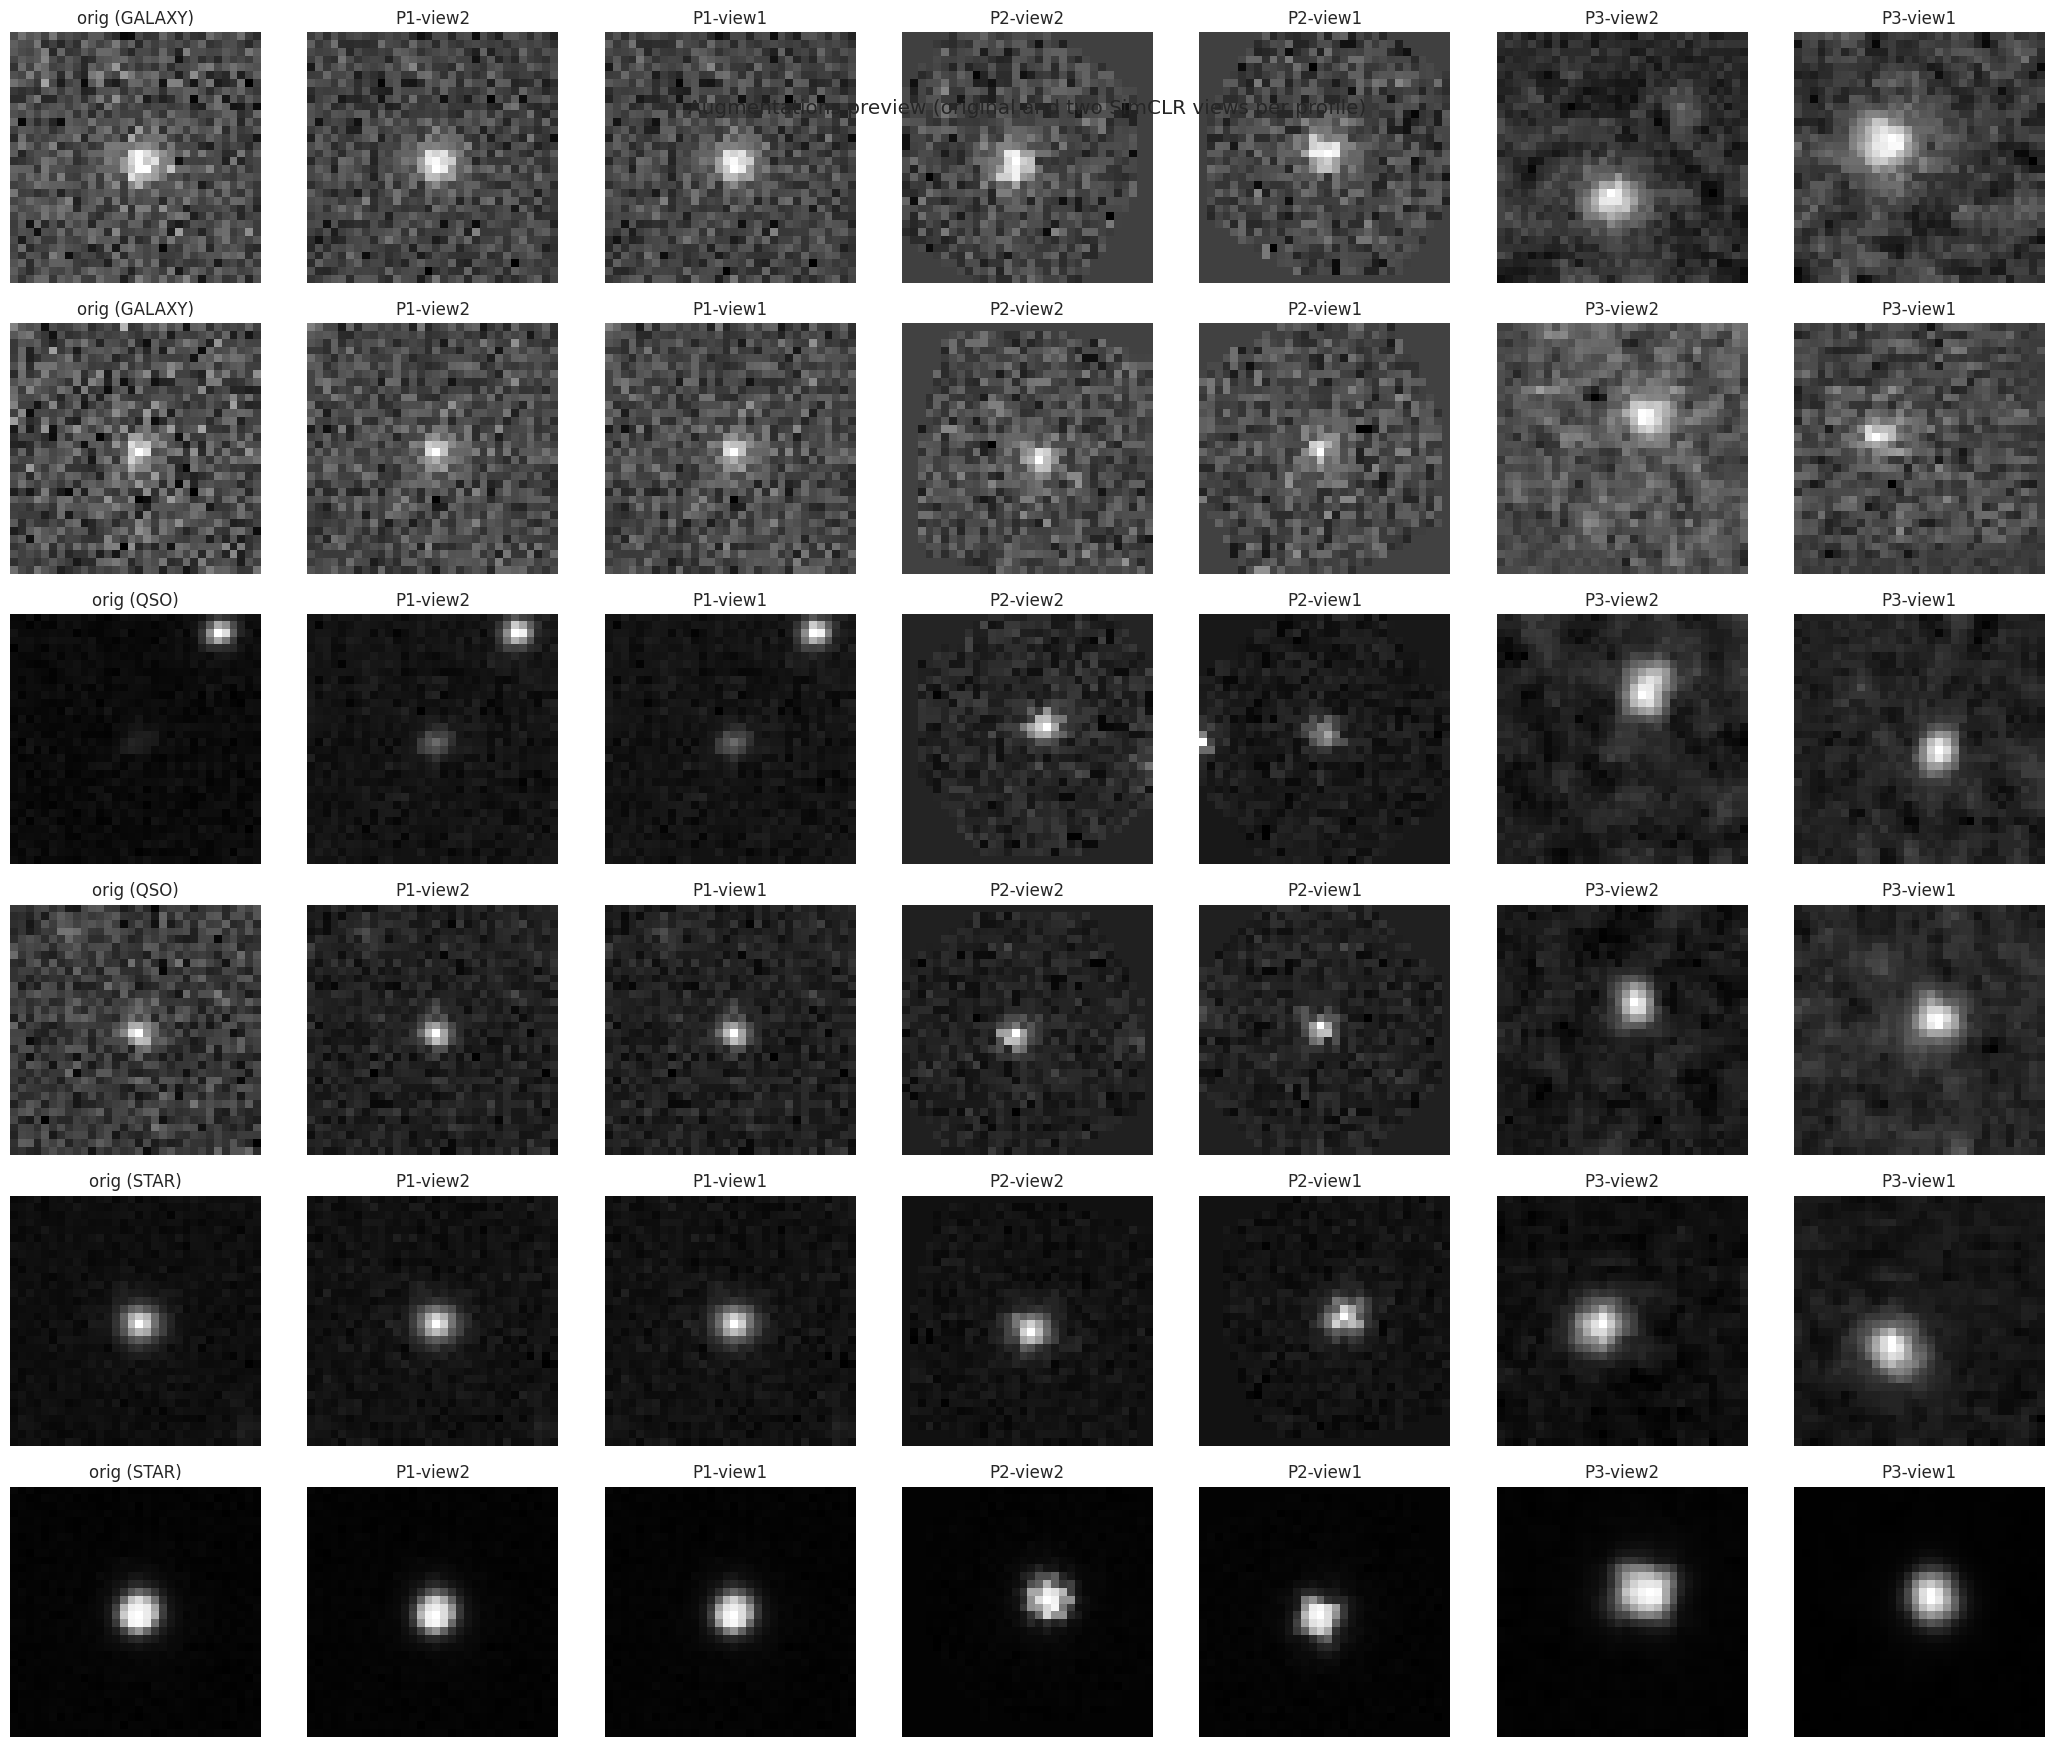

Encoder feature dim: 256

[Stage 1] SimCLR pretraining
  Epoch 001/40 | Loss: 4.3067
  Epoch 002/40 | Loss: 4.2783
  Epoch 003/40 | Loss: 4.2734
  Epoch 004/40 | Loss: 4.2717
  Epoch 005/40 | Loss: 4.2707
  Epoch 006/40 | Loss: 4.2704
  Epoch 007/40 | Loss: 4.2700
  Epoch 008/40 | Loss: 4.2696
  Epoch 009/40 | Loss: 4.2695
  Epoch 010/40 | Loss: 4.2692
  Epoch 011/40 | Loss: 4.2690
  Epoch 012/40 | Loss: 4.2686
  Epoch 013/40 | Loss: 4.2684
  Epoch 014/40 | Loss: 4.2683
  Epoch 015/40 | Loss: 4.2680
  Epoch 016/40 | Loss: 4.2679
  Epoch 017/40 | Loss: 4.2676
  Epoch 018/40 | Loss: 4.2674
  Epoch 019/40 | Loss: 4.2673
  Epoch 020/40 | Loss: 4.2670
  Epoch 021/40 | Loss: 4.2669
  Epoch 022/40 | Loss: 4.2668
  Epoch 023/40 | Loss: 4.2665
  Epoch 024/40 | Loss: 4.2664
  Epoch 025/40 | Loss: 4.2664
  Epoch 026/40 | Loss: 4.2660
  Epoch 027/40 | Loss: 4.2660
  Epoch 028/40 | Loss: 4.2658
  Epoch 029/40 | Loss: 4.2656
  Epoch 030/40 | Loss: 4.2656
  Epoch 031/40 | Loss: 4.2653
  Epoch 032/40 

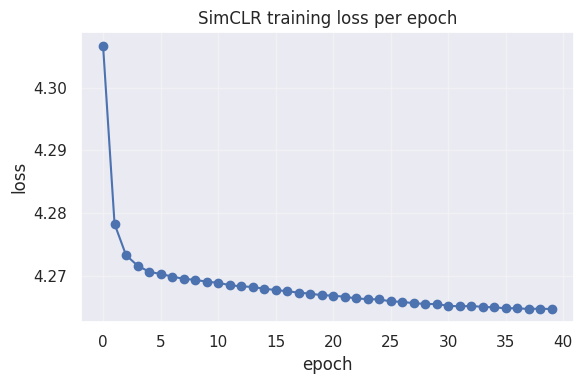


[Stage 2] MLP probe training (encoder frozen)
  Epoch 001/30 | Train Loss: 0.7705 | Holdout Loss: 0.5505
  Epoch 002/30 | Train Loss: 0.4564 | Holdout Loss: 0.3943
  Epoch 003/30 | Train Loss: 0.3669 | Holdout Loss: 0.3456
  Epoch 004/30 | Train Loss: 0.3335 | Holdout Loss: 0.3240
  Epoch 005/30 | Train Loss: 0.3159 | Holdout Loss: 0.3152
  Epoch 006/30 | Train Loss: 0.3028 | Holdout Loss: 0.3066
  Epoch 007/30 | Train Loss: 0.2928 | Holdout Loss: 0.3004
  Epoch 008/30 | Train Loss: 0.2853 | Holdout Loss: 0.2987
  Epoch 009/30 | Train Loss: 0.2800 | Holdout Loss: 0.2942
  Epoch 010/30 | Train Loss: 0.2743 | Holdout Loss: 0.2929
  Epoch 011/30 | Train Loss: 0.2713 | Holdout Loss: 0.2892
  Epoch 012/30 | Train Loss: 0.2644 | Holdout Loss: 0.2876
  Epoch 013/30 | Train Loss: 0.2621 | Holdout Loss: 0.2864
  Epoch 014/30 | Train Loss: 0.2592 | Holdout Loss: 0.2851
  Epoch 015/30 | Train Loss: 0.2554 | Holdout Loss: 0.2833
  Epoch 016/30 | Train Loss: 0.2503 | Holdout Loss: 0.2802
  Epoch 0

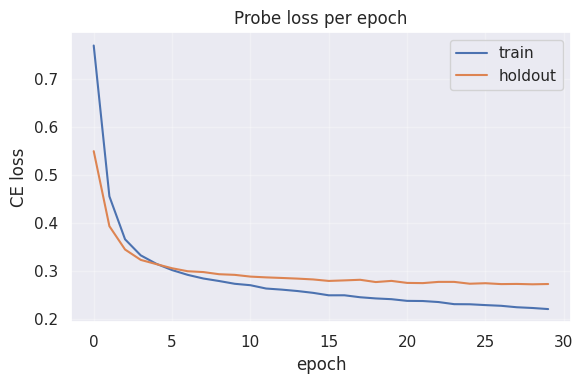


[Stage 3] Test metrics
Identified 27002 correct labels out of 30000 labels
Accuracy: 0.9000666666666667
Precision: 0.9007340191179108
Recall: 0.900033381327216
F1 Score: 0.9002242117974818
Labels are: ['GALAXY' 'QSO' 'STAR']
Confusion Matrix:
 [[9334  483  203]
 [ 452 8868  681]
 [ 172 1007 8800]]
Classification_Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.93     10020
           1       0.86      0.89      0.87     10001
           2       0.91      0.88      0.90      9979

    accuracy                           0.90     30000
   macro avg       0.90      0.90      0.90     30000
weighted avg       0.90      0.90      0.90     30000



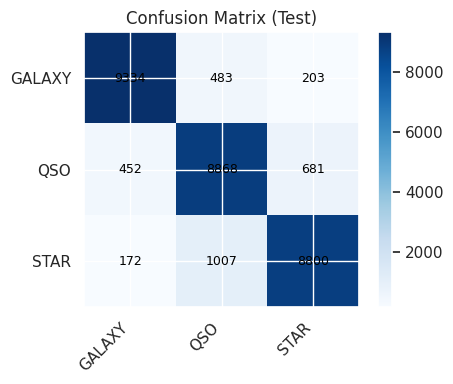

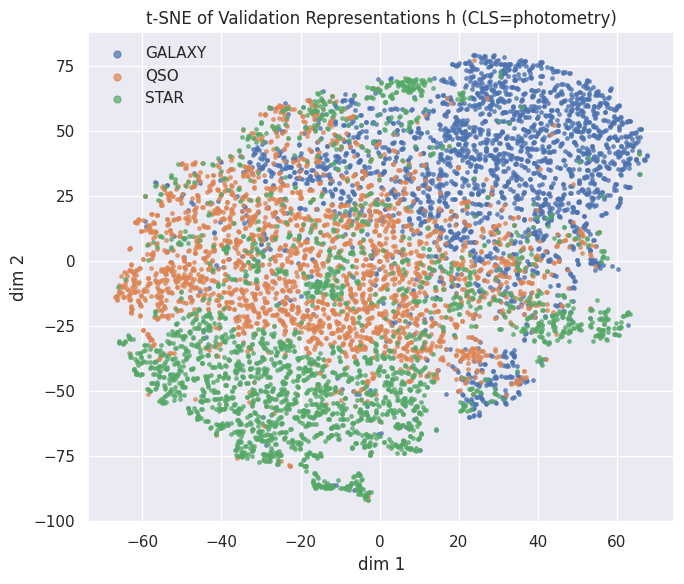

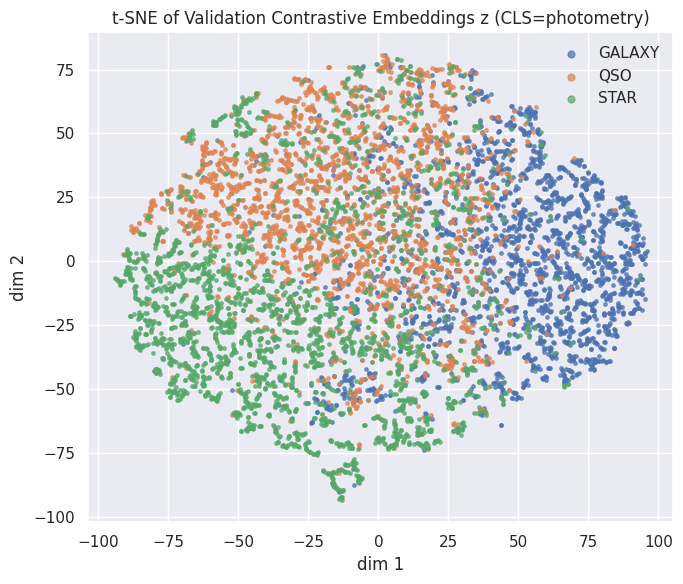

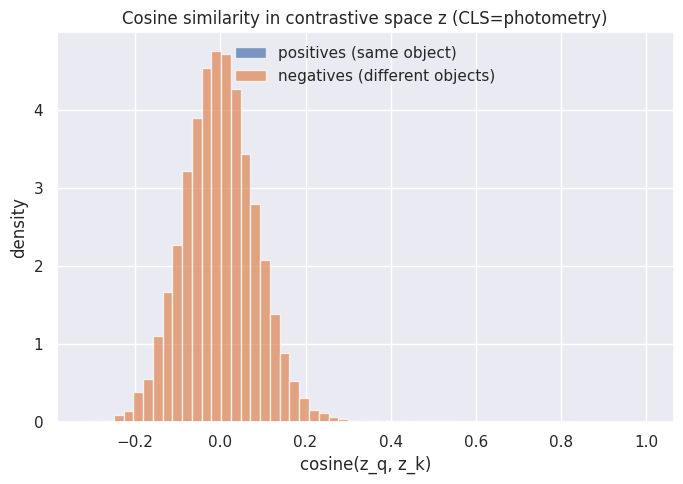

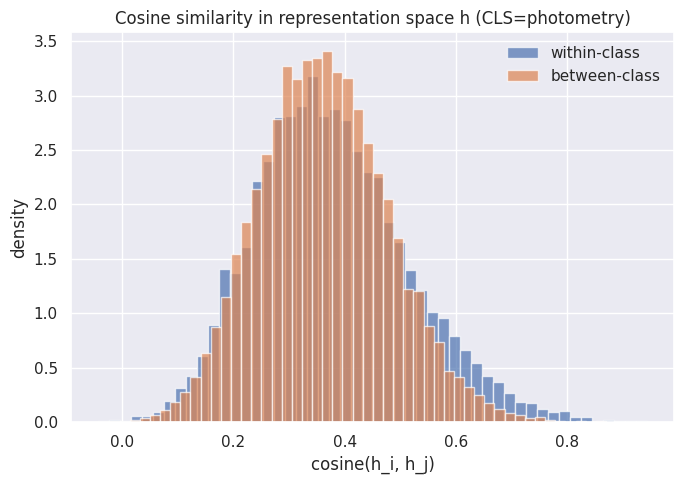

[transfer] No faint&compact test arrays provided; skipping.


In [7]:
# %% [markdown]
# # Contrastive Learning for StarGalaxyQuasar (SGQ) Classification with LinformerViT
#
# **Goal.** Learn robust multiband image representations via **SimCLR** and classify SGQ with a simple MLP probe.
#
# **Key ideas**
# - Use a **Vision Transformer** with **Linformer** attention (efficient in sequence length).
# - Feed **image patches** as tokens.
# - Provide a **switchable CLS token**:
#   - `"photometry"`: CLS derived from the **photometric feature vector** (e.g., SDSS u,g,r,i,z features).
#   - `"learnable"`: CLS is a global **learned** token (standard ViT style).
# - Train SimCLR on the **train** set, probe on the **validation** set, evaluate on the **test** set.
# - Visualize learned spaces with **UMAP/tSNE** and **cosine histograms**.
#
# **Dataset summary for this notebook (Experiment 1):**
# - Balanced, 32×32 multiband cutouts (5 channels).
# - Class counts (provided):
#   - **Train:** 59,988 (stars), 60,061 (galaxies), 59,962 (quasars)
#   - **Validation:** 10,033 (stars), 9,918 (galaxies), 10,037 (quasars)
#   - **Test:** 9,979 (stars), 10,020 (galaxies), 10,001 (quasars)
#
# **Transfer check (Experiment 3 idea):**
# - Optionally evaluate the encoder + probe on a **faint & compact** test set (if arrays are provided).
#
# **What you need already loaded in memory:**
# `X_train, dnnx_train, y_train`, `X_val, dnnx_val, y_val`, `X_test, dnnx_test, y_test`, `label_strings`, and `get_metrics`.
#
# ---

# %% [markdown]
# ## 1. Imports, device, reproducibility

# %%
import warnings; warnings.filterwarnings("ignore")

import math, time, copy, random
from typing import Tuple, Optional
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from torchvision.transforms import InterpolationMode

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Optional embedding reducers
USE_UMAP = True
try:
    import umap  # type: ignore
except Exception:
    USE_UMAP = False
from sklearn.manifold import TSNE

# Reproducibility
SEED = 69
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

def pick_device(preferred_index=0):
    if torch.cuda.is_available():
        n = torch.cuda.device_count()
        idx = preferred_index if preferred_index < n else 0
        print(f"[device] Using cuda:{idx} -> {torch.cuda.get_device_name(idx)}")
        return torch.device(f"cuda:{idx}")
    print("[device] CUDA not available. Using CPU.")
    return torch.device("cpu")

try:
    device  # keep existing if defined
except NameError:
    device = pick_device(0)

# %% [markdown]
# ## 2. Basic checks & dataset counts
# We assume you have already run the dataloading/splitting code and have:
# - `X_train, X_val, X_test` shaped `(N, 5, 32, 32)`
# - `dnnx_*` photometric features shaped `(N, F)`
# - `y_*` integer labels and `label_strings` from `pd.factorize`
# - `get_metrics(y_pred, y_true, labels, to_print=True)` utility
#
# We print shapes and compare observed class counts with the provided counts.

# %%
assert X_train.ndim == 4 and X_train.shape[1] == 5, "Expect X_* as (N, 5, H, W)"
H, W, C = X_train.shape[-2], X_train.shape[-1], X_train.shape[1]
PF_DIM = dnnx_train.shape[1]
N_CLASSES = len(np.unique(y_train))
print(f"Images: train={X_train.shape}, val={X_val.shape}, test={X_test.shape} | bands={C}, size={H}x{W}")
print(f"Photometry dims: {PF_DIM} | classes={N_CLASSES}")

def class_counts(y, names):
    vals, cnts = np.unique(y, return_counts=True)
    return {names[v]: int(c) for v, c in zip(vals, cnts)}

print("\n[Dataset counts]")
train_counts = class_counts(y_train, label_strings)
val_counts   = class_counts(y_val,   label_strings)
test_counts  = class_counts(y_test,  label_strings)
print(" Train :", train_counts)
print(" Val   :", val_counts)
print(" Test  :", test_counts)
print("\n(Expected) Train 59988/60061/59962 ; Val 10033/9918/10037 ; Test 9979/10020/10001 (stars/galaxies/quasars)")

# %% [markdown]
# ## 3. Background (MargNet paper summary, **not** this work)
# The MargNet paper (MNRAS 518, 31233136, 2023) introduced a deep learningbased SGQ classifier using SDSS DR16:
#
# - Input: **SDSS** images in **u,g,r,i,z** passbands and curated **photometric features**.
# - Quality cuts ensure **clean photometry** and reliable spectroscopy for labels (e.g., `zWarning=0`, `clean=1`, etc.).
# - They focus on **compact** and **faint & compact** sources, defining compactness \(c = \frac{\mathrm{deVRad}}{\mathrm{FWHM}}\) (averaged over bands).
# - They find classification becomes challenging when \(c \le 0.5\); for faintness they use mean magnitude \(>20\).
# - Experiments:
#   - **Exp 1**: Compact sources (train/val/test all compact).
#   - **Exp 2**: Faint & compact (train/val/test all faint & compact).
#   - **Exp 3**: Train/val on compact, **test on faint & compact** (transfer).
#
# **This notebook** follows the **Exp 1** recipe for contrastive pretraining and validation probing, then (optionally) evaluates transfer à la **Exp 3** if you supply a faint&compact test split (`X_test_faint`, `dnnx_test_faint`, `y_test_faint`).

# %% [markdown]
# ## 4. Sanitization and configuration
# We sanitize NaN/Inf values, set augmentation profiles, normalization, LinformerViT hyperparameters, and SimCLR/Probe settings.

# %%
def sanitize_np_inplace(arr, clip_percentiles: Optional[Tuple[float,float]] = None):
    np.nan_to_num(arr, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
    if clip_percentiles is not None:
        lo, hi = np.percentile(arr, clip_percentiles[0]), np.percentile(arr, clip_percentiles[1])
        np.clip(arr, lo, hi, out=arr)

# Gentle clipping on train images; sanitize everywhere
sanitize_np_inplace(X_train, clip_percentiles=(0.1, 99.9))
sanitize_np_inplace(X_val);  sanitize_np_inplace(X_test)
sanitize_np_inplace(dnnx_train); sanitize_np_inplace(dnnx_val); sanitize_np_inplace(dnnx_test)

# Augmentation profiles:
# 1 = none | 2 = Keras-like (rot/translate/flip) | 3 = stronger (2 + RRC + blur + noise)
AUG_PROFILE = 2

# Image normalization switches
FEATUREWISE_CENTER = False
FEATUREWISE_STD_NORM = False
SAMPLEWISE_CENTER = True
SAMPLEWISE_STD_NORM = True

# Photometry normalization
PHOTOMETRY_FEATUREWISE_STANDARDIZE = True

# CLS mode: "photometry" (PF-derived CLS) or "learnable" (global learnable CLS)
CLS_MODE = "photometry"   # change to "learnable" to ignore photometry for CLS

# Linformer-ViT hyperparameters
PATCH = 4
EMBED_DIM = 256
DEPTH = 8
HEADS = 8
MLP_RATIO = 4.0
DROPOUT = 0.0
ATTN_DROPOUT = 0.0
NUM_PATCH = (H // PATCH) * (W // PATCH)      # e.g., 8x8 = 64
SEQ_LEN = NUM_PATCH + 1                      # +1 for CLS
K_LINFORMER = min(32, SEQ_LEN)               # Linformer rank

# SimCLR
EPOCHS_CONTRAST = 40
LR_CONTRAST = 2e-4
TEMP = 0.5
PROJ_HIDDEN = 1024
PROJ_DIM = 128
CLIP_NORM = 1.0
USE_AMP = False

# Probe (MLP on h)
EPOCHS_CLS = 30
LR_CLS = 3e-4
WD_CLS = 1e-4
PATIENCE = 10
CLS_HIDDEN = 512

# Dataloaders
BATCH_CONTRASTIVE = 256
BATCH_EVAL = 512
NUM_WORKERS = 8
PIN = (device.type == "cuda")

print(f"[Config] AUG_PROFILE={AUG_PROFILE}, CLS_MODE={CLS_MODE}, PATCH={PATCH}, EMBED_DIM={EMBED_DIM}, HEADS={HEADS}, K={K_LINFORMER}")

# %% [markdown]
# ## 5. Transforms (images & photometry)
# We mirror **ImageDataGeneratorlike** settings and add a stronger SimCLR profile.  
# We also compute featurewise stats (trainonly) and implement perimage standardization.

# %%
img_mean = X_train.mean(axis=(0,2,3)).astype("float32")
img_std  = X_train.std(axis=(0,2,3)).astype("float32") + 1e-6
norm_mean, norm_std = img_mean.tolist(), img_std.tolist()

pf_mean = dnnx_train.mean(axis=0).astype("float32")
pf_std  = dnnx_train.std(axis=0).astype("float32") + 1e-6

class NanToNum:
    def __init__(self, nan=0.0, pos=0.0, neg=0.0): self.nan, self.pos, self.neg = nan, pos, neg
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        return torch.nan_to_num(x, nan=self.nan, posinf=self.pos, neginf=self.neg)

class SamplewiseStandardize:
    def __init__(self, center=True, scale=True, eps=1e-6):
        self.center, self.scale, self.eps = center, scale, eps
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        if self.center:
            x = x - x.mean(dim=(1,2), keepdim=True)
        if self.scale:
            std = x.std(dim=(1,2), keepdim=True)
            x = x / (std + self.eps)
        return x

class AddGaussianNoise:
    def __init__(self, std=0.01): self.std = std
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        return x + torch.randn_like(x)*self.std if self.std>0 else x

class PhotometryStandardize:
    def __init__(self, mean, std, do=True):
        self.mean = torch.from_numpy(mean).float()
        self.std  = torch.from_numpy(std).float()
        self.do = do
    def __call__(self, f: torch.Tensor) -> torch.Tensor:
        f = torch.nan_to_num(f, nan=0.0, posinf=0.0, neginf=0.0)
        if self.do:
            f = (f - self.mean.to(f.device)) / self.std.to(f.device)
        return f

def build_simclr_view_transform(profile:int):
    """Return a torchvision transform for the requested augmentation profile."""
    ops = [NanToNum()]
    if profile in (2, 3):
        ops += [
            transforms.RandomRotation(180),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1),
                                    interpolation=InterpolationMode.BILINEAR),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
        ]
    if profile == 3:
        ops += [
            transforms.RandomResizedCrop(size=(H, W), scale=(0.5, 1.0),
                                         interpolation=InterpolationMode.BILINEAR),
            transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
            AddGaussianNoise(0.01),
        ]
    if SAMPLEWISE_CENTER or SAMPLEWISE_STD_NORM:
        ops.append(SamplewiseStandardize(SAMPLEWISE_CENTER, SAMPLEWISE_STD_NORM))
    if FEATUREWISE_CENTER or FEATUREWISE_STD_NORM:
        ops.append(transforms.Normalize(
            mean=norm_mean if FEATUREWISE_CENTER else [0]*C,
            std=norm_std if FEATUREWISE_STD_NORM else [1]*C
        ))
    return transforms.Compose(ops)

class TwoCropsTransform:
    def __init__(self, base): self.base = base
    def __call__(self, x): return self.base(x), self.base(x)

eval_img_transform = transforms.Compose([
    NanToNum(),
    SamplewiseStandardize(SAMPLEWISE_CENTER, SAMPLEWISE_STD_NORM) if (SAMPLEWISE_CENTER or SAMPLEWISE_STD_NORM)
        else transforms.Lambda(lambda x: x),
    transforms.Normalize(mean=norm_mean if FEATUREWISE_CENTER else [0]*C,
                         std=norm_std if FEATUREWISE_STD_NORM else [1]*C)
])

pf_transform = PhotometryStandardize(pf_mean, pf_std, do=PHOTOMETRY_FEATUREWISE_STANDARDIZE)

# %% [markdown]
# ## 6. Onetime augmentation preview (Profiles 1, 2, 3)
# We visualize the **original** and the two SimCLR **views** for a few examples from each class, under **each profile**.
# Columns: **Original | P1v1 | P1v2 | P2v1 | P2v2 | P3v1 | P3v2**.  
# This cell runs **once**purely for qualitative inspection.

# %%
def tensor_to_gray_img(x_tensor):
    """x_tensor: CxHxW (float). Convert to grayscale for plotting."""
    x_np = x_tensor.cpu().numpy()
    g = x_np.mean(axis=0)  # average across bands
    g = g - g.min()
    g = g / (g.max() + 1e-8)
    return g

def show_aug_profiles(X_np, y_np, label_names, profiles=(1,2,3), n_per_class=2, seed=SEED):
    rng = np.random.default_rng(seed)
    idxs = []
    for ci in range(len(label_names)):
        cand = np.where(y_np == ci)[0]
        take = min(n_per_class, len(cand))
        if take > 0:
            idxs.extend(rng.choice(cand, size=take, replace=False))
    if not idxs:
        print("[aug preview] no indices found; skipping.")
        return
    # Build transforms per profile once
    tviews = {p: TwoCropsTransform(build_simclr_view_transform(p)) for p in profiles}

    nrows = len(idxs)
    ncols = 1 + 2*len(profiles)
    plt.figure(figsize=(3*ncols, 3*nrows))
    for r, i in enumerate(idxs):
        x = torch.from_numpy(X_np[i]).float()
        orig = tensor_to_gray_img(x)
        # first column: original
        ax = plt.subplot(nrows, ncols, r*ncols + 1)
        ax.imshow(orig, cmap='gray', vmin=0, vmax=1)
        ax.set_title(f"orig ({label_names[y_np[i]]})"); ax.axis('off')
        # remaining columns: per profile, two views
        c = 2
        for p in profiles:
            q, k = tviews[p](x)
            imgs = [tensor_to_gray_img(q), tensor_to_gray_img(k)]
            for img in imgs:
                ax = plt.subplot(nrows, ncols, r*ncols + c)
                ax.imshow(img, cmap='gray', vmin=0, vmax=1)
                ax.set_title(f"P{p}-view{(c-1)%2 + 1}")
                ax.axis('off')
                c += 1
    plt.suptitle("Augmentations preview (original and two SimCLR views per profile)", y=0.92)
    plt.tight_layout(); plt.show()

show_aug_profiles(X_train, y_train, label_strings, profiles=(1,2,3), n_per_class=2)

# %% [markdown]
# ## 7. Datasets & DataLoaders
# - **ContrastiveDataset** yields two augmented views of an image and the photometry vector.
# - **ImageClsDataset** yields a single (eval) view and photometry with optional label.

# %%
class ContrastiveDataset(Dataset):
    def __init__(self, X_np, F_np, transform_img, transform_pf):
        self.X, self.F = X_np, F_np
        self.timg = TwoCropsTransform(transform_img)
        self.tpf  = transform_pf
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i):
        x = torch.from_numpy(self.X[i]).float()     # CxHxW
        q, k = self.timg(x)
        f = torch.from_numpy(self.F[i]).float()
        f = self.tpf(f) if self.tpf else f
        return q, k, f

class ImageClsDataset(Dataset):
    def __init__(self, X_np, F_np, y_np=None, transform_img=None, transform_pf=None):
        self.X, self.F = X_np, F_np
        self.y = None if y_np is None else torch.from_numpy(y_np).long()
        self.timg = transform_img
        self.tpf = transform_pf
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i):
        x = torch.from_numpy(self.X[i]).float()
        if self.timg: x = self.timg(x)
        f = torch.from_numpy(self.F[i]).float()
        f = self.tpf(f) if self.tpf else f
        if self.y is None: return x, f
        return x, f, self.y[i]

# Loaders
train_contrastive_loader = DataLoader(
    ContrastiveDataset(X_train, dnnx_train, build_simclr_view_transform(AUG_PROFILE), pf_transform),
    batch_size=BATCH_CONTRASTIVE, shuffle=True, drop_last=True,
    num_workers=NUM_WORKERS, pin_memory=PIN, persistent_workers=True
)
val_loader = DataLoader(
    ImageClsDataset(X_val, dnnx_val, y_val, transform_img=eval_img_transform, transform_pf=pf_transform),
    batch_size=BATCH_EVAL, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN, persistent_workers=True
)
test_loader = DataLoader(
    ImageClsDataset(X_test, dnnx_test, y_test, transform_img=eval_img_transform, transform_pf=pf_transform),
    batch_size=BATCH_EVAL, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN, persistent_workers=True
)

# %% [markdown]
# ## 8. LinformerViT Encoder (CLS switch)
# - Patchify images with a strided `Conv2d` (`kernel=stride=PATCH`).
# - Add **patch positional embeddings**.
# - **CLS token** either:
#   - learned (global),
#   - or **projected from photometry** (our fusion strategy).
# - Run **Linformer selfattention** blocks and take the **CLS output** as representation `h`.

# %%
class LinformerSelfAttention(nn.Module):
    def __init__(self, dim, seq_len, k, heads=8, attn_drop=0.0, proj_drop=0.0):
        super().__init__()
        assert dim % heads == 0
        self.dim = dim
        self.heads = heads
        self.head_dim = dim // heads
        self.scale = self.head_dim ** -0.5
        self.seq_len = seq_len
        self.k = k

        self.qkv = nn.Linear(dim, dim*3, bias=False)
        self.E_k = nn.Parameter(torch.randn(seq_len, k) * (1.0 / math.sqrt(seq_len)))
        self.E_v = nn.Parameter(torch.randn(seq_len, k) * (1.0 / math.sqrt(seq_len)))
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):  # [B,N,D]
        B, N, D = x.shape
        assert N == self.seq_len
        qkv = self.qkv(x).reshape(B, N, 3, self.heads, self.head_dim).permute(2,0,3,1,4)
        q, k, v = qkv[0], qkv[1], qkv[2]            # [B,h,N,d]
        k_lin = torch.einsum('bhnd,nk->bhkd', k, self.E_k)  # [B,h,k,d]
        v_lin = torch.einsum('bhnd,nk->bhkd', v, self.E_v)  # [B,h,k,d]
        attn = (q @ k_lin.transpose(-2,-1)) * self.scale    # [B,h,N,k]
        attn = self.attn_drop(attn.softmax(dim=-1))
        out = (attn @ v_lin).transpose(1,2).reshape(B, N, D)  # [B,N,D]
        out = self.proj(out); out = self.proj_drop(out)
        return out

class TransformerBlock(nn.Module):
    def __init__(self, dim, seq_len, k_linformer, heads, mlp_ratio=4.0, drop=0.0, attn_drop=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = LinformerSelfAttention(dim, seq_len, k_linformer, heads, attn_drop, drop)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim*mlp_ratio)),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(int(dim*mlp_ratio), dim),
            nn.Dropout(drop),
        )
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class ViTLinformerCLS(nn.Module):
    def __init__(self, in_ch=C, img_size=(H,W), patch=PATCH, dim=EMBED_DIM,
                 depth=DEPTH, heads=HEADS, mlp_ratio=MLP_RATIO,
                 drop=DROPOUT, attn_drop=ATTN_DROPOUT,
                 pf_dim=PF_DIM, cls_mode="photometry",
                 k_linformer=K_LINFORMER):
        super().__init__()
        self.H, self.W = img_size
        self.patch = patch
        self.dim = dim
        self.num_patches = (self.H // patch) * (self.W // patch)
        self.seq_len = self.num_patches + 1  # +1 for CLS

        self.patch_embed = nn.Conv2d(in_ch, dim, kernel_size=patch, stride=patch, padding=0)
        self.pos_embed_patches = nn.Parameter(torch.zeros(1, self.num_patches, dim))
        nn.init.trunc_normal_(self.pos_embed_patches, std=0.02)

        self.cls_mode = cls_mode
        if cls_mode == "learnable":
            self.cls_token = nn.Parameter(torch.zeros(1, 1, dim))
            nn.init.trunc_normal_(self.cls_token, std=0.02)
            self.pf_proj = None
        else:
            self.pf_proj = nn.Sequential(
                nn.Linear(pf_dim, dim),
                nn.GELU(),
                nn.LayerNorm(dim)
            )
            self.cls_token = None
        self.cls_pos = nn.Parameter(torch.zeros(1, 1, dim))
        nn.init.trunc_normal_(self.cls_pos, std=0.02)

        self.pos_drop = nn.Dropout(drop)
        self.blocks = nn.ModuleList([
            TransformerBlock(dim, seq_len=self.seq_len, k_linformer=k_linformer,
                             heads=heads, mlp_ratio=mlp_ratio, drop=drop, attn_drop=attn_drop)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(dim)

    def forward(self, x_img, x_pf=None):
        B = x_img.shape[0]
        x = self.patch_embed(x_img)                 # [B,D,H/P,W/P]
        x = x.flatten(2).transpose(1, 2)            # [B,N,D]
        x = x + self.pos_embed_patches

        if self.cls_mode == "learnable":
            cls = self.cls_token.expand(B, -1, -1)  # [B,1,D]
        else:
            assert x_pf is not None, "photometry features required for cls_mode='photometry'"
            cls = self.pf_proj(x_pf).unsqueeze(1)   # [B,1,D]

        tokens = torch.cat([cls + self.cls_pos, x], dim=1)  # [B,1+N,D]
        tokens = self.pos_drop(tokens)
        for blk in self.blocks: tokens = blk(tokens)
        tokens = self.norm(tokens)
        h = tokens[:, 0, :]                          # CLS output (representation)
        return h  # [B, D]

# Quick sanity check
encoder = ViTLinformerCLS(cls_mode=CLS_MODE).to(device)
with torch.no_grad():
    _h = encoder(torch.zeros(2, C, H, W, device=device),
                 torch.zeros(2, PF_DIM, device=device) if CLS_MODE=="photometry" else None)
print("Encoder feature dim:", _h.shape[1])
FEAT_DIM = EMBED_DIM

# %% [markdown]
# ## 9. SimCLR components (projector + NTXent)
# - `SimCLR`: wraps the encoder and projection head.
# - `NTXentLoss`: **correct InfoNCE** building a **2B×2B** similarity matrix, masking the diagonal, and assigning the proper positive index for each row.

# %%
class SimCLR(nn.Module):
    def __init__(self, encoder: nn.Module, feat_dim: int, proj_dim: int = PROJ_DIM, hidden: int = PROJ_HIDDEN):
        super().__init__()
        self.encoder = encoder
        self.projector = nn.Sequential(
            nn.Linear(feat_dim, hidden),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, proj_dim)
        )
    def forward(self, img, pf=None):
        h = self.encoder(img, pf)                               # [B, D]
        z = F.normalize(self.projector(h), dim=1, eps=1e-8)     # normalized for cosine sim
        return h, z

class NTXentLoss(nn.Module):
    def __init__(self, temperature: float = 0.5): super().__init__(); self.tau = temperature
    def forward(self, z1, z2):
        B = z1.size(0)
        z = torch.cat([z1, z2], dim=0)                         # [2B, D]
        sim = (z @ z.t()) / self.tau                           # cosine sim if z normalized
        mask = torch.eye(2*B, device=z.device, dtype=torch.bool)
        sim = sim.masked_fill(mask, -1e9)                      # large negative (avoid -inf NaNs)
        pos = torch.arange(B, 2*B, device=z.device)
        labels = torch.cat([pos, torch.arange(0, B, device=z.device)], dim=0)  # [2B]
        return F.cross_entropy(sim, labels)

simclr = SimCLR(encoder, feat_dim=FEAT_DIM).to(device)
criterion_contrast = NTXentLoss(temperature=TEMP)

# %% [markdown]
# ## 10. SimCLR pretraining (Stage1)
# Train on **train** set (labels unused). We log the loss curve.

# %%
opt = torch.optim.Adam(simclr.parameters(), lr=LR_CONTRAST, weight_decay=1e-6)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS_CONTRAST)
scaler = torch.cuda.amp.GradScaler(enabled=(USE_AMP and device.type=='cuda'))

simclr_train_losses = []
print("\n[Stage 1] SimCLR pretraining")
for epoch in range(1, EPOCHS_CONTRAST+1):
    simclr.train()
    running = 0.0; n_img = 0
    for q, k, f in train_contrastive_loader:
        q = q.to(device, non_blocking=True)
        k = k.to(device, non_blocking=True)
        f = f.to(device, non_blocking=True)

        opt.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(USE_AMP and device.type=='cuda')):
            _, z_q = simclr(q, f if CLS_MODE=="photometry" else None)
            _, z_k = simclr(k, f if CLS_MODE=="photometry" else None)
            loss = criterion_contrast(z_q, z_k)

        if not torch.isfinite(loss):
            print("  [warn] Non-finite loss; skipping batch."); continue

        if scaler.is_enabled():
            scaler.scale(loss).backward(); scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(simclr.parameters(), CLIP_NORM)
            scaler.step(opt); scaler.update()
        else:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(simclr.parameters(), CLIP_NORM)
            opt.step()

        running += loss.item() * q.size(0); n_img += q.size(0)
    sched.step()
    epoch_loss = running / max(1,n_img)
    simclr_train_losses.append(epoch_loss)
    print(f"  Epoch {epoch:03d}/{EPOCHS_CONTRAST} | Loss: {epoch_loss:.4f}")

plt.figure(figsize=(6,4))
plt.plot(simclr_train_losses, marker='o')
plt.title("SimCLR training loss per epoch")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

# %% [markdown]
# ## 11. Linear/MLP probe on validation (Stage2)
# Freeze the encoder and train a small MLP on `h` using the **validation** set.
# We use a small holdout split inside validation for early stopping.

# %%
for p in simclr.encoder.parameters(): p.requires_grad = False
simclr.eval()

classifier = nn.Sequential(
    nn.Linear(FEAT_DIM, CLS_HIDDEN),
    nn.ReLU(inplace=True),
    nn.Dropout(0.2),
    nn.Linear(CLS_HIDDEN, N_CLASSES)
).to(device)

# split validation into train/holdout
val_indices = np.arange(X_val.shape[0])
rng = np.random.default_rng(SEED); rng.shuffle(val_indices)
split = int(0.9 * len(val_indices))
val_train_idx, val_hold_idx = val_indices[:split], val_indices[split:]

val_train_loader = DataLoader(
    Subset(ImageClsDataset(X_val, dnnx_val, y_val, eval_img_transform, pf_transform), val_train_idx),
    batch_size=BATCH_EVAL, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN, persistent_workers=True
)
val_hold_loader = DataLoader(
    Subset(ImageClsDataset(X_val, dnnx_val, y_val, eval_img_transform, pf_transform), val_hold_idx),
    batch_size=BATCH_EVAL, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN, persistent_workers=True
)

opt_cls = torch.optim.Adam(classifier.parameters(), lr=LR_CLS, weight_decay=WD_CLS)
sched_cls = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_cls, mode='min', factor=0.5, patience=3, verbose=True)

best_hold = float('inf'); best_state = None; no_imp = 0
cls_hold_losses = []; cls_train_losses = []

print("\n[Stage 2] MLP probe training (encoder frozen)")
for epoch in range(1, EPOCHS_CLS+1):
    classifier.train(); run = 0.0; n = 0
    for xb, fb, yb in val_train_loader:
        xb, fb, yb = xb.to(device), fb.to(device), yb.to(device)
        with torch.no_grad(): h, _ = simclr(xb, fb if CLS_MODE=="photometry" else None)
        logits = classifier(h.detach()); loss = F.cross_entropy(logits, yb)
        opt_cls.zero_grad(set_to_none=True); loss.backward(); opt_cls.step()
        run += loss.item()*xb.size(0); n += xb.size(0)
    tr_loss = run/max(1,n); cls_train_losses.append(tr_loss)

    classifier.eval(); hold = 0.0; m = 0
    with torch.no_grad():
        for xb, fb, yb in val_hold_loader:
            xb, fb, yb = xb.to(device), fb.to(device), yb.to(device)
            h, _ = simclr(xb, fb if CLS_MODE=="photometry" else None)
            logits = classifier(h); loss = F.cross_entropy(logits, yb)
            hold += loss.item()*xb.size(0); m += xb.size(0)
    hv_loss = hold/max(1,m); cls_hold_losses.append(hv_loss); sched_cls.step(hv_loss)
    print(f"  Epoch {epoch:03d}/{EPOCHS_CLS} | Train Loss: {tr_loss:.4f} | Holdout Loss: {hv_loss:.4f}")

    if hv_loss < best_hold - 1e-5:
        best_hold = hv_loss; best_state = copy.deepcopy(classifier.state_dict()); no_imp = 0
    else:
        no_imp += 1
        if no_imp >= PATIENCE:
            print(f"  Early stopping at epoch {epoch} (best holdout loss: {best_hold:.4f})"); break
if best_state is not None: classifier.load_state_dict(best_state)

plt.figure(figsize=(6,4))
plt.plot(cls_train_losses, label="train")
plt.plot(cls_hold_losses, label="holdout")
plt.title("Probe loss per epoch")
plt.xlabel("epoch"); plt.ylabel("CE loss"); plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

# %% [markdown]
# ## 12. Test evaluation (Stage3) + Confusion Matrix
# Evaluate the MLP probe (encoder frozen) on the **test** set, print metrics, and display the confusion matrix.

# %%
simclr.eval(); classifier.eval()
all_preds, all_gts = [], []
with torch.no_grad():
    for xb, fb, yb in test_loader:
        xb, fb = xb.to(device), fb.to(device)
        h, _ = simclr(xb, fb if CLS_MODE=="photometry" else None)
        logits = classifier(h)
        all_preds.append(logits.argmax(dim=1).cpu().numpy())
        all_gts.append(yb.numpy())
y_pred = np.concatenate(all_preds); y_true = np.concatenate(all_gts)

print("\n[Stage 3] Test metrics")
_ = get_metrics(y_pred, y_true, labels=label_strings, to_print=True)

cm = confusion_matrix(y_true, y_pred, labels=np.arange(N_CLASSES))
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix (Test)"); plt.colorbar()
plt.xticks(np.arange(N_CLASSES), label_strings, rotation=45, ha='right')
plt.yticks(np.arange(N_CLASSES), label_strings)
for i in range(N_CLASSES):
    for j in range(N_CLASSES):
        plt.text(j, i, int(cm[i,j]), ha='center', va='center', color='black', fontsize=9)
plt.tight_layout(); plt.show()

# %% [markdown]
# ## 13. Embedding extraction on validation
# We extract both the **representation** `h` (CLS output) and the **contrastive embedding** `z` (projected) on the **validation** set for downstream visualization.

# %%
val_feats_h, val_feats_z, val_labels = [], [], []
simclr.eval()
with torch.no_grad():
    for xb, fb, yb in val_loader:
        xb, fb = xb.to(device), fb.to(device)
        h, z = simclr(xb, fb if CLS_MODE=="photometry" else None)
        val_feats_h.append(h.cpu().numpy())
        val_feats_z.append(z.cpu().numpy())
        val_labels.append(yb.numpy())
val_feats_h = np.concatenate(val_feats_h, 0)
val_feats_z = np.concatenate(val_feats_z, 0)
val_labels  = np.concatenate(val_labels, 0)

def subsample(X, y, max_n=8000, seed=SEED):
    if X.shape[0] <= max_n: return X, y
    idx = np.random.default_rng(seed).choice(X.shape[0], size=max_n, replace=False)
    return X[idx], y[idx]

feats_h_2d_src, labels_2d = subsample(val_feats_h, val_labels, 8000)
feats_z_2d_src, _          = subsample(val_feats_z, val_labels, 8000)

# %% [markdown]
# ## 14. UMAP/tSNE: validation embeddings (`h`) and contrastive (`z`)
# We visualize the structure of:
# - **h**: the representation space the classifier reads,
# - **z**: the contrastive space where InfoNCE acts.
#
# Separation/clustering patterns here are strong qualitative diagnostics.

# %%
if USE_UMAP:
    reducer_h = umap.UMAP(n_neighbors=30, min_dist=0.1, metric='cosine', random_state=SEED)
    reducer_z = umap.UMAP(n_neighbors=30, min_dist=0.1, metric='cosine', random_state=SEED)
    title_method = "UMAP"
else:
    reducer_h = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=SEED)
    reducer_z = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=SEED)
    title_method = "t-SNE"

feats_h_2d = reducer_h.fit_transform(feats_h_2d_src)
feats_z_2d = reducer_z.fit_transform(feats_z_2d_src)

plt.figure(figsize=(7,6))
for ci, cname in enumerate(label_strings):
    m = (labels_2d == ci)
    plt.scatter(feats_h_2d[m,0], feats_h_2d[m,1], s=6, alpha=0.7, label=str(cname))
plt.title(f"{title_method} of Validation Representations h (CLS={CLS_MODE})")
plt.legend(markerscale=2, frameon=False); plt.xlabel("dim 1"); plt.ylabel("dim 2"); plt.tight_layout(); plt.show()

plt.figure(figsize=(7,6))
for ci, cname in enumerate(label_strings):
    m = (labels_2d == ci)
    plt.scatter(feats_z_2d[m,0], feats_z_2d[m,1], s=6, alpha=0.7, label=str(cname))
plt.title(f"{title_method} of Validation Contrastive Embeddings z (CLS={CLS_MODE})")
plt.legend(markerscale=2, frameon=False); plt.xlabel("dim 1"); plt.ylabel("dim 2"); plt.tight_layout(); plt.show()

# %% [markdown]
# ## 15. Cosinesimilarity histograms
# **Contrastive space `z`** (positives vs. negatives) and **representation space `h`** (within vs. between classes).
# These should show **positive pairs** clustering at higher cosine than negatives, and **withinclass** > **betweenclass** in `h`.

# %%
def cosine_hist_val_contrastive(simclr, device, target_pairs=20000):
    """Positive/negative cosine distributions in contrastive space z using validation with aug."""
    loader = DataLoader(
        ContrastiveDataset(X_val, dnnx_val, build_simclr_view_transform(AUG_PROFILE), pf_transform),
        batch_size=512, shuffle=True, drop_last=False, num_workers=NUM_WORKERS, pin_memory=PIN
    )
    pos_sims, neg_sims = [], []
    simclr.eval()
    with torch.no_grad():
        collected = 0
        for q, k, f in loader:
            q = q.to(device); k = k.to(device); f = f.to(device)
            _, z_q = simclr(q, f if CLS_MODE=="photometry" else None)
            _, z_k = simclr(k, f if CLS_MODE=="photometry" else None)
            if z_q.size(0) < 2:  # skip tiny batches
                continue
            sim_pos = (z_q * z_k).sum(dim=1).detach().cpu().numpy()
            pos_sims.append(sim_pos)
            perm = torch.randperm(z_k.size(0), device=z_k.device)
            same = (perm == torch.arange(z_k.size(0), device=z_k.device))
            if same.any(): perm[same] = (perm[same] + 1) % z_k.size(0)
            z_k_neg = z_k[perm]
            sim_neg = (z_q * z_k_neg).sum(dim=1).detach().cpu().numpy()
            neg_sims.append(sim_neg)
            collected += sim_pos.shape[0]
            if collected >= target_pairs: break
    pos = np.concatenate(pos_sims)[:target_pairs] if pos_sims else np.array([0.0])
    neg = np.concatenate(neg_sims)[:target_pairs] if neg_sims else np.array([0.0])
    return pos, neg

def pairwise_cosine_hist(feats, labels, max_pairs=30000, seed=SEED):
    rng = np.random.default_rng(seed)
    feats = feats / (np.linalg.norm(feats, axis=1, keepdims=True) + 1e-8)
    n = feats.shape[0]
    pos_vals, neg_vals = [], []
    for _ in range(max_pairs):
        i, j = rng.integers(0, n), rng.integers(0, n)
        if i == j: continue
        c = float(np.dot(feats[i], feats[j]))
        if labels[i] == labels[j]: pos_vals.append(c)
        else: neg_vals.append(c)
    return np.array(pos_vals), np.array(neg_vals)

pos_z, neg_z = cosine_hist_val_contrastive(simclr, device, target_pairs=20000)
plt.figure(figsize=(7,5))
plt.hist(pos_z, bins=50, alpha=0.7, density=True, label="positives (same object)")
plt.hist(neg_z, bins=50, alpha=0.7, density=True, label="negatives (different objects)")
plt.title(f"Cosine similarity in contrastive space z (CLS={CLS_MODE})")
plt.xlabel("cosine(z_q, z_k)"); plt.ylabel("density"); plt.legend(frameon=False); plt.tight_layout(); plt.show()

pos_h, neg_h = pairwise_cosine_hist(val_feats_h, val_labels, max_pairs=30000)
plt.figure(figsize=(7,5))
plt.hist(pos_h, bins=50, alpha=0.7, density=True, label="within-class")
plt.hist(neg_h, bins=50, alpha=0.7, density=True, label="between-class")
plt.title(f"Cosine similarity in representation space h (CLS={CLS_MODE})")
plt.xlabel("cosine(h_i, h_j)"); plt.ylabel("density"); plt.legend(frameon=False); plt.tight_layout(); plt.show()

# %% [markdown]
# ## 16. (Optional) Transfer test (Experiment 3 flavor)
# If you provide `X_test_faint`, `dnnx_test_faint`, and `y_test_faint`, we will evaluate the same frozen encoder + probe on the **faint & compact** test set to mimic **Exp 3**.

# %%
def evaluate_optional_transfer():
    try:
        X_ft = X_test_faint; F_ft = dnnx_test_faint; y_ft = y_test_faint
    except NameError:
        print("[transfer] No faint&compact test arrays provided; skipping.")
        return
    loader_ft = DataLoader(
        ImageClsDataset(X_ft, F_ft, y_ft, transform_img=eval_img_transform, transform_pf=pf_transform),
        batch_size=BATCH_EVAL, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN
    )
    simclr.eval(); classifier.eval()
    preds, gts = [], []
    with torch.no_grad():
        for xb, fb, yb in loader_ft:
            xb, fb = xb.to(device), fb.to(device)
            h, _ = simclr(xb, fb if CLS_MODE=="photometry" else None)
            logits = classifier(h)
            preds.append(logits.argmax(dim=1).cpu().numpy())
            gts.append(yb.numpy())
    yp = np.concatenate(preds); yt = np.concatenate(gts)
    print("\n[Transfer] Faint & Compact Test set metrics (Exp 3 style)")
    _ = get_metrics(yp, yt, labels=label_strings, to_print=True)
    cm_ft = confusion_matrix(yt, yp, labels=np.arange(N_CLASSES))
    plt.figure(figsize=(5,4))
    plt.imshow(cm_ft, cmap="Purples")
    plt.title("Confusion Matrix (Faint & Compact Transfer)"); plt.colorbar()
    plt.xticks(np.arange(N_CLASSES), label_strings, rotation=45, ha='right')
    plt.yticks(np.arange(N_CLASSES), label_strings)
    for i in range(N_CLASSES):
        for j in range(N_CLASSES):
            plt.text(j, i, int(cm_ft[i,j]), ha='center', va='center', color='black', fontsize=9)
    plt.tight_layout(); plt.show()

evaluate_optional_transfer()

# %% [markdown]
# ## 17. Notes and next steps
# - **CLS choice**: Toggle `CLS_MODE` between `"photometry"` and `"learnable"` to see the effect of photometric fusion.
# - **Augmentations**: Adjust `AUG_PROFILE` (1,2,3). Profile3 is stronger (RRC+blur+noise).
# - **Linformer rank** `K_LINFORMER`: Lowering increases speed; try 1632.
# - **Projector**: sweep `PROJ_HIDDEN` (512/1024/2048) and `PROJ_DIM` (64/128/256).
# - **Transfer**: Provide faint & compact arrays to run the optional transfer cell (Exp3style).
# - **Analysis**: Use UMAP/tSNE plots, cosine histograms, and confusion matrices as qualitative & quantitative diagnostics.
